# Connection

In [1]:
!pip install findspark

In [2]:
import findspark
findspark.init() 

In [3]:
import pyspark
from pyspark.sql import SparkSession
import pyarrow.parquet as pq
import s3fs

In [4]:
spark = SparkSession.builder.appName("Dummy").master('local').config("spark.driver.memory", "60g").config('spark.dirver.maxResultSize', '6g').getOrCreate()
print("session = ", spark.getActiveSession())
config_spark_s3_adv = {'spark.driver.maxResultSize':0,
                      }


spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)
spark.conf.set("spark.sql.adaptive.enabled", "false")

23/01/09 15:26:45 WARN Utils: Your hostname, ecs-test288 resolves to a loopback address: 127.0.1.1; using 10.11.10.114 instead (on interface eth0)
23/01/09 15:26:45 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/09 15:26:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/01/09 15:26:47 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


session =  <pyspark.sql.session.SparkSession object at 0x7f8eabbfcee0>


# Load raw data

In [5]:
s3 = s3fs.S3FileSystem(key='WA0NJOX0AFAY4K1J92XZ',
                       secret='du3wAsX0uzEBBn4AdkFpCX4ZTXvSWFVG48GA4jbT',  
                       client_kwargs={
                           'endpoint_url':'https://obs.ru-moscow-1.hc.sbercloud.ru'
                           })

In [6]:
ratings_path = 's3://okko-prod/pipelines/etl-ratings_0.1/202211082359/outgoing/ratings.parquet'

In [7]:
ratings = pq.ParquetDataset(ratings_path, filesystem=s3,memory_map=True).read_pandas().to_pandas()
ratings.head().T

,0,1,2,3,4
ts,2022-07-29 12:03:18,2016-07-31 09:23:01,2022-05-21 11:32:15,2022-03-01 14:52:31,2022-04-25 11:09:59
user_uid,00000000-0000-0000-0000-000000000000,00000000-0000-0000-0000-000000000000,00000000-0000-0000-0000-000000000000,00000000-0000-0000-0000-000000000000,00000000-0000-0000-0000-000000000000
element_uid,01e4f704-efe8-4f18-aa14-402e0b751df2,0d19d7f8-d656-467b-b3b4-516490b8f981,0f62bf59-31ae-4455-84b8-ae513756ef11,114a6693-6544-492a-8e04-45801f6aecb1,1435f1ee-987b-47bf-8fd8-3fc74e3447eb
rating,10,6,10,10,10


In [8]:
ratings.shape

(39213680, 4)

In [9]:
ratings['rating'].unique()

array([10,  6,  0,  8,  5,  9,  7,  4,  3,  2,  1, 55], dtype=int32)

In [10]:
ratings['rating'].value_counts()

10    32876130
8      1828299
9      1599935
7       875083
6       559301
2       363760
0       337580
5       261706
4       246115
1       161938
3       103831
55           2
Name: rating, dtype: int64

In [11]:
ratings = ratings[ratings['rating']  != 55]

In [12]:
ratings.shape

(39213678, 4)

In [13]:
len(ratings['element_uid'].unique())

30943

In [14]:
rat = ratings.groupby('element_uid')['rating'].agg("mean")

In [15]:
rat

element_uid
                                         8.167084
000d6913-68a1-4135-9bad-9bcd71708b2e     5.591837
000e14b2-2a9a-463d-9e4e-ef37511a57b6    10.000000
000eea36-e76a-4fff-b540-8bd71ae4d3de     9.531532
0014721f-5910-41fd-bfea-732b0789ff94     0.000000
                                          ...    
ffeb6d52-2062-4ec4-851d-a0255fe0fc5d     6.318182
ffee7968-06a5-4fb8-919c-c50209f24f27     4.500000
ffefbe8f-7edb-4bf2-b999-42f82d74fbcb     9.426523
fff15902-2da2-4daf-854d-054bf38ece7c     8.666667
fff8228d-52c9-423c-90f2-d9d8879d0124     7.933333
Name: rating, Length: 30943, dtype: float64

In [16]:
rat.shape

(30943,)

In [18]:
import pickle

with open('elements_available_KINOPOISK.pkl', 'rb') as f:
    full_df = pickle.load(f)

In [19]:
full_df.shape

(38825, 17)

In [20]:
full_df = full_df.reset_index()

In [21]:
full_df.rename(columns = {'index':'element_uid'}, inplace = True)

In [22]:
full_df


,element_uid,age_access_type,name,availability,director,alias,genre,average_rating,subscription_only,type,sale_start_date,digital_uid,country,release_type,uid,release_year,duration,actor
0,42c5cbc6-7a44-4f7b-a620-d86f43290d1d,12,"Энни Лейбовиц: Жизнь, увиденная через объектив",NaN,[4551ef07-32ff-43aa-92dc-35fd175479df],annie-leibovitz-life-through-a-lens,"[Documentary, 5c403894-146a-47a4-ae75-9f1956a3...",6.0,False,MOVIE,1301947200000,14059,[usa],RELEASE,42c5cbc6-7a44-4f7b-a620-d86f43290d1d,2006,4800000,"[6cf76651-d5e4-46db-8384-0993d3431992, 3de5e2c..."
1,04579553-398a-4aa9-a672-e841ed4a6380,12,Мисс Конгениальность 2: Прекрасна и опасна,NaN,[db533e1d-08c8-46b9-a3b7-997eaf2009bf],miss-congeniality-2-armed-fabulous,"[Action, Comedy, 364fdc2e-bdfe-40be-b2c5-d30f4...",6.11,False,MOVIE,1306612800000,18978,"[usa, australia-6400]",RELEASE,04579553-398a-4aa9-a672-e841ed4a6380,2005,6900000,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 358e2a7..."
2,e785baa6-f175-42b4-9e16-4319ac7991d5,12,Звёздный путь 5: Последний рубеж,"[DTO, RENT, SUBSCRIPTION]",[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],star-trek-v-the-final-frontier,"[Sci-Fi, Action, Thriller, Adventure]",6.21,False,MOVIE,1277323200000,2870,[usa],RELEASE,e785baa6-f175-42b4-9e16-4319ac7991d5,1989,6420000,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 21c7a45..."
3,f3921ca6-7441-46cc-a83a-c6beee368bf0,12,Как раз под Рождество,NaN,[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],just-in-time-for-christmas,"[Comedy, Melodrama]",5.97,False,MOVIE,1526984637772,97651,"[usa, canada]",RELEASE,f3921ca6-7441-46cc-a83a-c6beee368bf0,2015,5580000,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, 39124be..."
4,5197752b-c863-4858-a12e-76d65c0a93e5,18,Американский психопат 2: Стопроцентная американка,NaN,[8416a09a-9127-4727-8ca2-ae04d7246016],american-psycho-ii-all-american-girl,"[Thriller, Horror]",5.61,False,MOVIE,1366361283109,38641,[usa],RELEASE,5197752b-c863-4858-a12e-76d65c0a93e5,2002,5280000,"[cff3362f-ad91-498d-80b3-ea3ab8ec65cf, c31972f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38820,08c51c97-699d-475a-9d3d-99b10ac3ce78,0,Крик о помощи,"[SUBSCRIPTION, AVOD]",[6ca20b2d-338b-4d31-ac69-7867620fbb56],krik-o-pomoshchi,[Drama],6.6,False,MP_MOVIE,1663167870375,403804810,[ussr],RELEASE,08c51c97-699d-475a-9d3d-99b10ac3ce78,1988,8160000,"[d3ebad48-33d3-4861-9da4-496f1b35f287, e95e709..."
38821,2bbb8495-d9d1-4375-bda3-3906f0b9d5ce,0,Академия пана Кляксы,[SUBSCRIPTION],[4f8cd651-29a1-499f-b1cb-722327ee1849],akademija-pana-kljaksy,"[Adventure, Family]",7.16,True,MP_MOVIE,1663578947252,34561,"[ussr, poland]",RELEASE,2bbb8495-d9d1-4375-bda3-3906f0b9d5ce,1984,9960000,[24aff49e-7ef4-4c2f-8588-92ca2a3ee737]
38822,e23d3b38-3c93-48b3-8bad-33a59e47574f,12,Прекрасная Елена,NaN,[ae00fe55-df7a-4ec6-8018-859aaa50b999],la-belle-helene,"[Music, 7b7c97f6-1adb-4b43-bfe8-9455812fac0b, ...",NaN,False,MP_MOVIE,NaN,409888980,[france],RELEASE,e23d3b38-3c93-48b3-8bad-33a59e47574f,2015,7800000,[7d3ef9e0-de96-4bc0-b61a-8d11482b9088]
38823,12c78e70-8b75-4dcc-97bc-83f3ded71c9a,12,Большой концерт народов или Дыхание «Чейн-Стокса»,"[SUBSCRIPTION, AVOD]",[6b026c80-123f-4692-b9ef-7d458c5be3ed],bolshojj-koncert-narodov-ili-dykhanie-chejjn-s...,[Documentary],NaN,False,MP_MOVIE,1663167870375,403804808,[ussr],RELEASE,12c78e70-8b75-4dcc-97bc-83f3ded71c9a,1991,8220000,"[d1de955f-daa1-4c1f-9c45-5575ee03ff3d, 1ea9de0..."


In [23]:
ddd = full_df.merge(rat,
                   on='element_uid',
                   how='inner')

In [26]:
ddd.shape

(30191, 19)

In [27]:
ddd.head().T

,0,1,2,3,4
element_uid,42c5cbc6-7a44-4f7b-a620-d86f43290d1d,04579553-398a-4aa9-a672-e841ed4a6380,e785baa6-f175-42b4-9e16-4319ac7991d5,f3921ca6-7441-46cc-a83a-c6beee368bf0,5197752b-c863-4858-a12e-76d65c0a93e5
age_access_type,12,12,12,12,18
name,"Энни Лейбовиц: Жизнь, увиденная через объектив",Мисс Конгениальность 2: Прекрасна и опасна,Звёздный путь 5: Последний рубеж,Как раз под Рождество,Американский психопат 2: Стопроцентная американка
availability,NaN,NaN,"[DTO, RENT, SUBSCRIPTION]",NaN,NaN
director,[4551ef07-32ff-43aa-92dc-35fd175479df],[db533e1d-08c8-46b9-a3b7-997eaf2009bf],[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],[1a6c76d5-cc63-43c5-a1fe-a8720c9aced6],[8416a09a-9127-4727-8ca2-ae04d7246016]
alias,annie-leibovitz-life-through-a-lens,miss-congeniality-2-armed-fabulous,star-trek-v-the-final-frontier,just-in-time-for-christmas,american-psycho-ii-all-american-girl
genre,"[Documentary, 5c403894-146a-47a4-ae75-9f1956a3...","[Action, Comedy, 364fdc2e-bdfe-40be-b2c5-d30f4...","[Sci-Fi, Action, Thriller, Adventure]","[Comedy, Melodrama]","[Thriller, Horror]"
average_rating,6.0,6.11,6.21,5.97,5.61
subscription_only,False,False,False,False,False
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE


In [30]:
ddd.isna().sum()

element_uid              0
age_access_type          0
name                     0
availability         10871
director                 8
alias                    0
genre                    0
average_rating        2208
subscription_only        0
type                     0
sale_start_date         95
digital_uid              0
country                  0
release_type             0
uid                      0
release_year             0
duration                15
actor                    1
rating                   0
dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


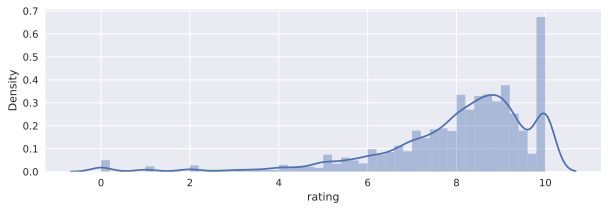

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


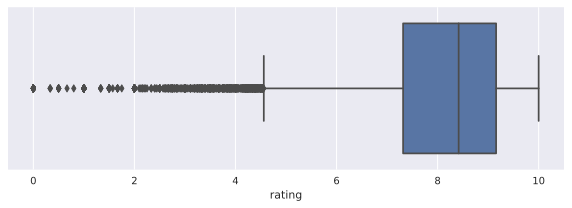

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(ddd['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(ddd['rating'], orient='h')
plt.show()

In [28]:
import numpy as np

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


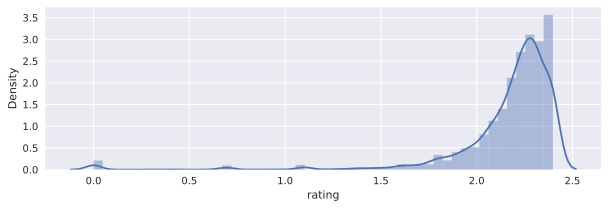

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


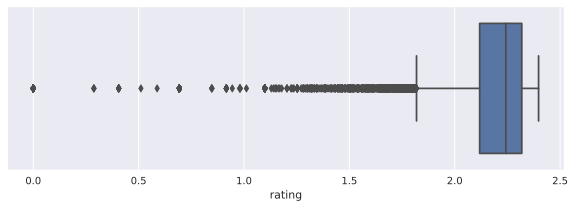

In [29]:
plt.figure(figsize=(10, 3))
sns.distplot(np.log1p(ddd['rating']))
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(np.log1p(ddd['rating']), orient='h')
plt.show()

In [49]:
import pickle

with open('NEW_OKKO_ratings_df.pkl', 'wb') as f:
    pickle.dump(ddd, f)

# Merge ratings okko and parsed KINOPOISK

In [42]:
import pickle

with open('Kinop_ratings_parsed_data_added.pkl', 'rb') as f:
    full_df_kinop = pickle.load(f)

In [43]:
full_df_kinop.columns

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD'],
      dtype='object')

In [44]:
full_df_kinop['element_id'] = full_df_kinop['element_uid']

In [45]:
data_kinop_parsed = full_df_kinop.merge(rat,
                   on='element_uid',
                   how='inner')

In [46]:
data_kinop_parsed.shape

(10731, 27)

In [47]:
data_kinop_parsed.head().T

,0,1,2,3,4
age_access_type,12,16,18,18,18
name,Звёздный путь 5: Последний рубеж,Звёздный путь 6: Неоткрытая страна,В поисках древнего артефакта,Прожарка Чарли Шина,Прожарка Уильяма Шэтнера
director,[cff3362f-ad91-498d-80b3-ea3ab8ec65cf],[bab6b7f4-4506-458f-9091-d567505674f2],[895f5774-964a-4c5a-ae22-d697d3e3e620],[1de22aff-430e-4af9-bf1d-159dbf8e9269],[1de22aff-430e-4af9-bf1d-159dbf8e9269]
genre,"[Sci-Fi, Action, Thriller, Adventure]","[Sci-Fi, Action, Thriller, Adventure]",[Horror],"[Comedy, Documentary]",[Comedy]
average_rating,6.21,7.2,4.0,6.99,6.0
type,MOVIE,MOVIE,MOVIE,MOVIE,MOVIE
country,[usa],[usa],[usa],[usa],[usa]
release_type,RELEASE,RELEASE,RELEASE,RELEASE,RELEASE
release_year,1989,1991,2019,2011,2006
duration,6420000.0,6780000.0,6000000.0,3780000.0,3780000.0


In [ ]:
import pickle

with open('NEW_OKKO_KINOP_parsed_ratings_df.pkl', 'wb') as f:
    pickle.dump(data_kinop_parsed, f)